# Predicting vaccination rates in the US


## Models used:

- `Regularised regression`
- `Random Forest regression`
- `Gradient Boosted Decision Trees`
- `SVM`?
- `NN`?


### Normalisation:

- `Regularised regression`



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sklearn
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor


In [2]:
base = os.path.split(os.getcwd())[0]
dd = base + '/data/'

In [3]:
df_all = pd.read_csv(dd + 'data_after_imputation.csv')

In [4]:
df_all.columns

Index(['fips', 'state', 'county', 'state_abb', 'pop_full_12plus_per',
       'pop_full_18plus_per', 'pop_full_65plus_per', 'cases_prop',
       'death_prop', 'hesitant_unsure', 'hesitant_strongly', 'SVI', 'SVI_cat',
       'CVAC', 'CVAC_cat', 'Hispanic (%)',
       'non-Hispanic American Indian/Alaska Native (%)',
       'non-Hispanic Asian (%)', 'non-Hispanic Black (%)',
       'non-Hispanic Native Hawaiian/Pacific Islander (%)',
       'non-Hispanic White (%)', 'noHealthInsurance', 'noHighSchool',
       'Poverty', 'SES', 'WBSeg', 'WNWSeg', 'pop_census', 'logPopDensity',
       'Urban_rural_code', 'PrematureDeath', 'Smoking',
       'anycondition_prevalence', 'Obesity_prevalence',
       'Heart disease_prevalence', 'COPD_prevalence', 'diabetes_prevalence',
       'CKD_prevalence', 'per_dem', 'per_voted', 'Testing', 'Traffic',
       'DaytimePopDensity', 'ToxPi Score'],
      dtype='object')

In [5]:
df_all.isnull().sum()[df_all.isnull().sum() > 1]

pop_full_12plus_per     55
pop_full_18plus_per    266
pop_full_65plus_per      8
dtype: int64

### Drop `NaN` from target:

In [6]:
df = df_all[df_all['pop_full_12plus_per'].notna()]

## Split data into `train`, `val` and `test` samples.

- keep `fips` for now to be able to explore, which counties were not well predicted.
- predict `pop_full_12plus_per` for now.


- Discuss: `val` sample? `test_size` = ?
- Note dropping categorical features `SVI_cat` and `CVAC_cat`

In [7]:
y = df['pop_full_12plus_per']
X = df.drop(columns = ['state_abb', 'pop_full_12plus_per',
                       'pop_full_18plus_per', 'pop_full_65plus_per',
                       'SVI_cat', 'CVAC_cat'])

#### `y_test` - leave until final model has been picked.

In [8]:
X_train_val_fips, X_test_fips, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [9]:
print('test data shape:', y_test.shape)

test data shape: (611,)


#### Get a validation sample?

In [10]:
X_train_fips, X_val_fips, y_train, y_val = train_test_split(X_train_val_fips, y_train_val,
                                                           test_size = 0.2, random_state = 42)

In [11]:
print('train data shape:', y_train.shape)
print('val data shape:', y_val.shape)

train data shape: (1953,)
val data shape: (489,)


#### Drop `fips` for modelling

In [12]:
X_test = X_test_fips.drop(columns = ['fips','state', 'county'])
X_train = X_train_fips.drop(columns = ['fips','state', 'county'])
X_val = X_val_fips.drop(columns = ['fips','state', 'county'])

-------
## Individual models:

---------
## Regularised regression:

`Ridge` / `Lasso`

#### To consider:

- outliers
- transfor of rights skewed data
- optimise `lambda`(default = 1; alpha = 0 - OLS). Larger alpha specify stronger regularisation and the coefficients become more robust to collinearity. 

----------
## Random Forest Regression:

- No scaling of the data.
- RF might be trickier when combining categorical and continuous data, as RF will give more weight to continuous features especially in calculating the feature_importances. RF is likely to give more weight to parameters with more levels.

- optimise 
    - `n_estimators` (number of random trees), 
    - `max_features` (the number of randomly selected features in each tree, if max_features is close to the total number of features, the trees are more likely to be similar. How diverse the trees are, the default for regression is log2 total number of features. Smaller values tend to reduce overfitting.
    - `max_depth` – the depth of each tree in the ensemble (default=None, splits until all leaves are pure).


#### Train base model prior to optimising Ho:


- overfitting! `RF_base rho: 0.964`

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF_base rho: 0.968
R2 score: 0.930
MAE: 2.474



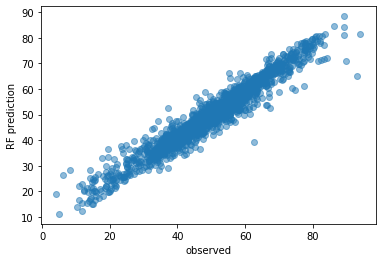

In [13]:
rf_base = RandomForestRegressor()

rf_base.fit(X_train, y_train)
y_train_rf_base = rf_base.predict(X_train)

print('RF_base rho: {:.3f}'.format(spearmanr(y_train,y_train_rf_base)[0]))
print('R2 score: {:.3f}'.format(r2_score(y_train,y_train_rf_base)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_train,y_train_rf_base)))
print()
plt.scatter(y_train,y_train_rf_base, alpha = 0.5)
plt.xlabel('observed'), plt.ylabel('RF prediction')
plt.show()

### Feature importance:

In [14]:
feature_names = X_train.columns

importances = rf_base.feature_importances_

std = np.std([
    tree.feature_importances_ for tree in rf_base.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending = False)

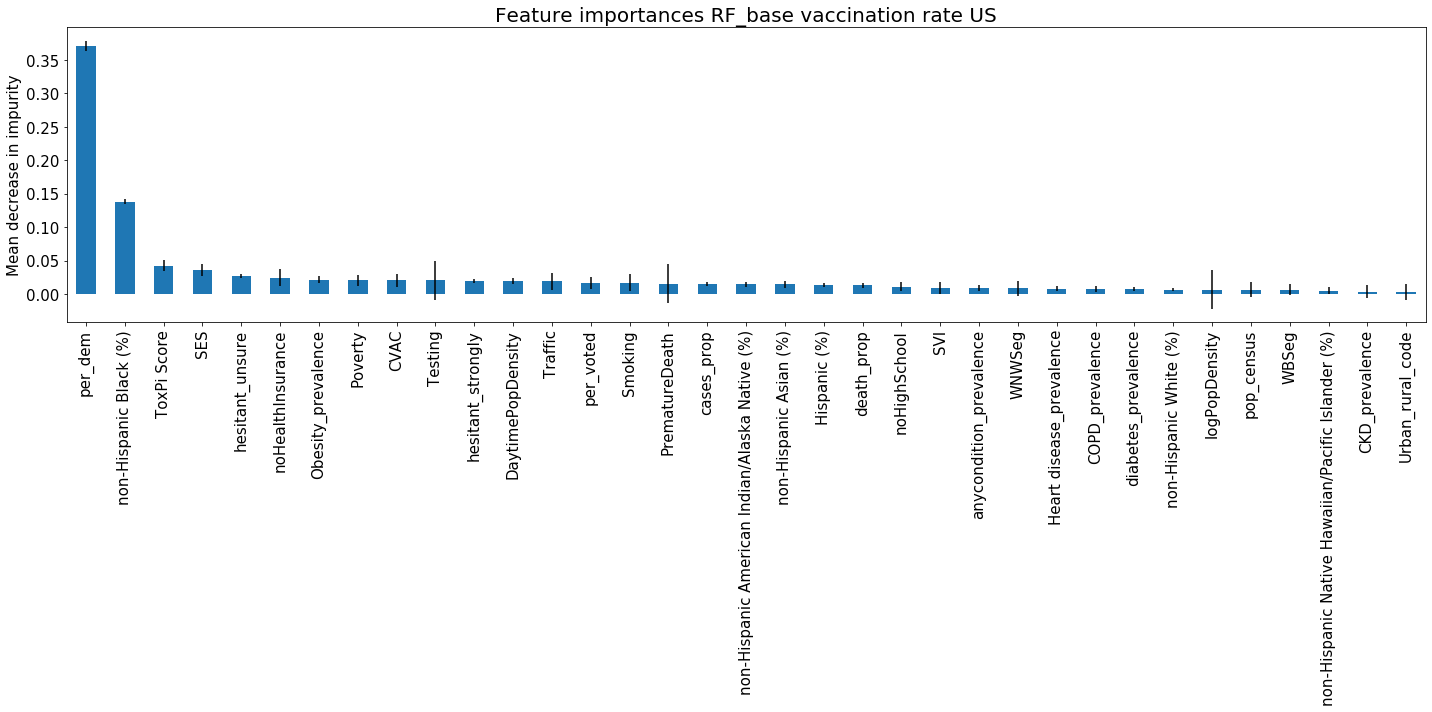

In [15]:

fig, ax = plt.subplots(figsize = (20,10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances RF_base vaccination rate US" , fontsize=20)

ax.set_ylabel("Mean decrease in impurity", fontsize = 15)

ax.tick_params(axis='both', which='major', labelsize = 15)

fig.tight_layout()

from sklearn.inspection import permutation_importance

result = permutation_importance(rf_base, X_train, y_train, n_repeats=5,
                                random_state=42)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

### Hyperparam optimisation:

In [16]:
search_param = {'n_estimators': [10, 100, 500, 1000],
               'max_features':('auto', 'sqrt'),
               'max_depth': [5, 15, 20, 50]}

#search = GridSearchCV(rf_base, param_grid = search_param,
#                     cv = 5, scoring = 'neg_mean_absolute_error')

#search.fit(X_train, y_train)

In [17]:
#print(search.best_params_)
#print(search.best_score_)

### Updated RandomForest:

####  `GridSearchCV` takes ~15 min to run so results are saved below:

RF_base rho: 0.982
R2 score: 0.951
MAE: 2.176



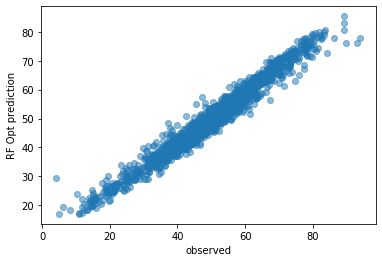

In [18]:
rf_opt = RandomForestRegressor(n_estimators = 1000, max_features = 'auto', max_depth = 20)

rf_opt.fit(X_train, y_train)
y_train_rf_opt = rf_opt.predict(X_train)

print('RF_base rho: {:.3f}'.format(spearmanr(y_train,y_train_rf_opt)[0]))
print('R2 score: {:.3f}'.format(r2_score(y_train,y_train_rf_opt)))
print('MAE: {:.3f}'.format(mean_absolute_error(y_train,y_train_rf_opt)))
print()
plt.scatter(y_train,y_train_rf_opt, alpha = 0.5)
plt.xlabel('observed'), plt.ylabel('RF Opt prediction')
plt.show()

### Validation set:

`rf_base` vs `rf_opt`

Rho: Base 0.786880, Opt 0.785295
MAE: Base 6.397137, Opt 6.169717
R2: Base 0.577695, Opt 0.586414


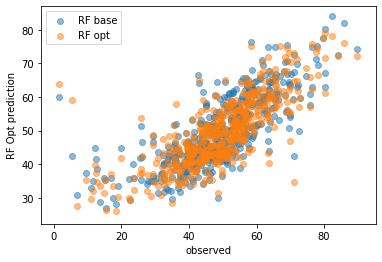

In [20]:
y_val_rf_base = rf_base.predict(X_val)
y_val_rf_opt = rf_opt.predict(X_val)


print('Rho: Base {:2f}, Opt {:2f}'.format(spearmanr(y_val,y_val_rf_base)[0],
                                     spearmanr(y_val,y_val_rf_opt)[0]))
print('MAE: Base {:2f}, Opt {:2f}'.format(mean_absolute_error(y_val,y_val_rf_base),
                                     mean_absolute_error(y_val,y_val_rf_opt)))
print('R2: Base {:2f}, Opt {:2f}'.format(r2_score(y_val,y_val_rf_base),
                                     r2_score(y_val,y_val_rf_opt)))

plt.scatter(y_val,y_val_rf_base, alpha = 0.5, label = 'RF base')
plt.scatter(y_val,y_val_rf_opt, alpha = 0.5, label = 'RF opt')
plt.xlabel('observed'), plt.ylabel('RF Opt prediction')
plt.legend()
plt.show()

### Explore counties with large errors:

#### abs(`obs` - `pred`) > 20

In [21]:
d = {'obs': y_val.values,
    'pred': y_val_rf_opt}
x_val_rf_pred = pd.DataFrame(data = d)
x_val_rf_pred['error'] = x_val_rf_pred['obs'] - x_val_rf_pred['pred']

In [22]:
X_val_fips_error = pd.concat( [X_val_fips.reset_index(drop = True), x_val_rf_pred.reset_index(drop = True)], axis=1)
X_val_fips_error.head(n = 3)

,fips,state,county,cases_prop,death_prop,hesitant_unsure,hesitant_strongly,SVI,CVAC,Hispanic (%),...,CKD_prevalence,per_dem,per_voted,Testing,Traffic,DaytimePopDensity,ToxPi Score,obs,pred,error
0,26001,Michigan,Alcona County,9.053340,0.374820,0.1717,0.0600,0.26,0.37,0.0150,...,4.5,0.303228,0.678904,2249.0,12.143237,13.1,0.447609,55.1,51.046239,4.053761
1,9009,Connecticut,New Haven County,12.019790,0.259021,0.0854,0.0318,0.52,0.04,0.1811,...,2.8,0.580480,0.489004,4697.0,550.060850,1362.4,0.461122,77.5,73.441901,4.058099
2,29043,Missouri,Christian County,14.269428,0.173825,0.1946,0.0855,0.15,0.45,0.0295,...,2.8,0.237644,0.528687,1831.0,65.429545,117.6,0.430476,48.6,50.465218,-1.865218


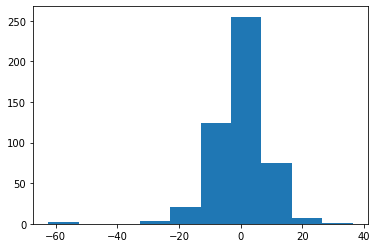

In [23]:
plt.hist(X_val_fips_error['error'])
plt.show()

In [24]:
X_val_fips_error[abs(X_val_fips_error['error']) > 20]

,fips,state,county,cases_prop,death_prop,hesitant_unsure,hesitant_strongly,SVI,CVAC,Hispanic (%),...,CKD_prevalence,per_dem,per_voted,Testing,Traffic,DaytimePopDensity,ToxPi Score,obs,pred,error
3,42053,Pennsylvania,Forest County,21.222575,0.317373,0.1849,0.0878,0.71,0.54,0.0554,...,3.4,0.275132,0.365117,4429.0,22.080382,14.2,0.443240,71.2,34.824921,36.375079
104,46089,South Dakota,McPherson County,12.694409,0.294241,0.1485,0.0747,0.29,0.12,0.0131,...,4.0,0.167674,0.556536,1093.0,6.134701,2.1,0.477249,12.5,37.468876,-24.968876
137,25001,Massachusetts,Barnstable County,7.902249,0.238039,0.0612,0.0312,0.06,0.00,0.0310,...,3.3,0.611967,0.705784,3690.0,65.380735,532.5,0.499337,5.5,59.239800,-53.739800
145,50005,Vermont,Caledonia County,4.947821,0.033341,0.0939,0.0224,0.27,0.31,0.0160,...,3.1,0.557301,0.539092,8242.0,52.297211,47.5,0.488079,36.1,57.971080,-21.871080
149,54105,West Virginia,Wirt County,12.867205,0.171792,0.1524,0.0747,0.37,0.44,0.0047,...,4.0,0.175650,0.455764,5566.0,0.065980,18.2,0.555453,6.7,27.590845,-20.890845
211,13049,Georgia,Charlton County,16.039427,0.388292,0.2723,0.1224,0.88,0.95,0.0837,...,3.7,0.241900,0.341099,680.0,27.798933,12.1,0.554278,12.9,34.657860,-21.757860
217,25019,Massachusetts,Nantucket County,8.943195,0.151235,0.0603,0.0310,0.03,0.01,0.0416,...,2.5,0.717356,0.640933,3123.0,0.000000,236.8,0.379504,1.5,63.922700,-62.422700
258,28063,Mississippi,Jefferson County,13.319027,0.472103,0.2810,0.1211,0.96,0.97,0.0722,...,5.7,0.850678,0.559514,2389.0,13.027174,13.7,0.493065,69.8,46.967700,22.832300
277,13055,Georgia,Chattooga County,17.681230,0.367098,0.2414,0.1079,0.93,0.92,0.0515,...,3.8,0.184478,0.405422,1763.0,63.186996,73.0,0.632376,15.0,35.242684,-20.242684
287,8025,Colorado,Crowley County,38.112523,0.329979,0.1484,0.0582,0.89,0.62,0.3186,...,3.2,0.249714,0.288731,8513.0,5.744853,5.0,0.499863,20.0,41.807552,-21.807552


In [29]:
X_val_fips_error[abs(X_val_fips_error['error']) > 60]

,fips,state,county,cases_prop,death_prop,hesitant_unsure,hesitant_strongly,SVI,CVAC,Hispanic (%),...,CKD_prevalence,per_dem,per_voted,Testing,Traffic,DaytimePopDensity,ToxPi Score,obs,pred,error
217,25019,Massachusetts,Nantucket County,8.943195,0.151235,0.0603,0.031,0.03,0.01,0.0416,...,2.5,0.717356,0.640933,3123.0,0.0,236.8,0.379504,1.5,63.9227,-62.4227


In [28]:
df_all[df_all['fips'] == 25019]

,fips,state,county,state_abb,pop_full_12plus_per,pop_full_18plus_per,pop_full_65plus_per,cases_prop,death_prop,hesitant_unsure,...,Heart disease_prevalence,COPD_prevalence,diabetes_prevalence,CKD_prevalence,per_dem,per_voted,Testing,Traffic,DaytimePopDensity,ToxPi Score
1192,25019,Massachusetts,Nantucket County,MA,1.5,1.6,2.9,8.943195,0.151235,0.0603,...,5.5,5.0,8.1,2.5,0.717356,0.640933,3123.0,0.0,236.8,0.379504
